In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [23]:
# Cargar datos
X_train = pd.read_pickle('data_wines/x_train_alpha(0.002).pkl').values.astype(float)

In [24]:
# Estandarizar datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [25]:
# Definir el autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoded_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoded_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoded_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [26]:
# Entrenar el autoencoder
input_dim = X_train.shape[1]
encoded_dim = 10
autoencoder = Autoencoder(input_dim, encoded_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [27]:
num_epochs = 100
for epoch in range(num_epochs):
    inputs = torch.from_numpy(X_train).float()
    encoded, decoded = autoencoder(inputs)
    loss = criterion(decoded, inputs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs,
                                                   loss.item()))

Epoch [10/100], Loss: 1.2293
Epoch [20/100], Loss: 1.1601
Epoch [30/100], Loss: 1.0230
Epoch [40/100], Loss: 0.9995
Epoch [50/100], Loss: 0.9992
Epoch [60/100], Loss: 0.9954
Epoch [70/100], Loss: 0.9759
Epoch [80/100], Loss: 0.9557
Epoch [90/100], Loss: 0.9438
Epoch [100/100], Loss: 0.9381


In [28]:
# Guardar el modelo entrenado
torch.save(autoencoder.encoder, 'models/autoencoder.pt')

# Load the saved encoder model
# encoder = torch.load('models/autoencoder.pt')
# with torch.no_grad():
#     encoded_X_train = encoder(torch.from_numpy(X_train)).numpy()

In [29]:
# Extraer las características codificadas
encoded_features, _ = autoencoder(torch.from_numpy(X_train).float())
encoded_features = encoded_features.detach().numpy()

# Guardar las características codificadas en un archivo
encoded_features_df = pd.DataFrame(encoded_features)
encoded_features_df.to_pickle('data_wines/encoded_features/encoded_features.pkl')

In [30]:
# Realizar clustering usando las características codificadas
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=0, n_init=10).fit(encoded_features)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(encoded_features, cluster_labels)
    print(f'Number of clusters: {n}, Silhouette Score: {silhouette_avg}')

Number of clusters: 2, Silhouette Score: 0.4471880793571472
Number of clusters: 3, Silhouette Score: 0.5199881792068481
Number of clusters: 4, Silhouette Score: 0.508314311504364
Number of clusters: 5, Silhouette Score: 0.4628434181213379
Number of clusters: 6, Silhouette Score: 0.46480926871299744
Number of clusters: 7, Silhouette Score: 0.4699183404445648
Number of clusters: 8, Silhouette Score: 0.4346769154071808
Number of clusters: 9, Silhouette Score: 0.43659624457359314
Number of clusters: 10, Silhouette Score: 0.4239238202571869


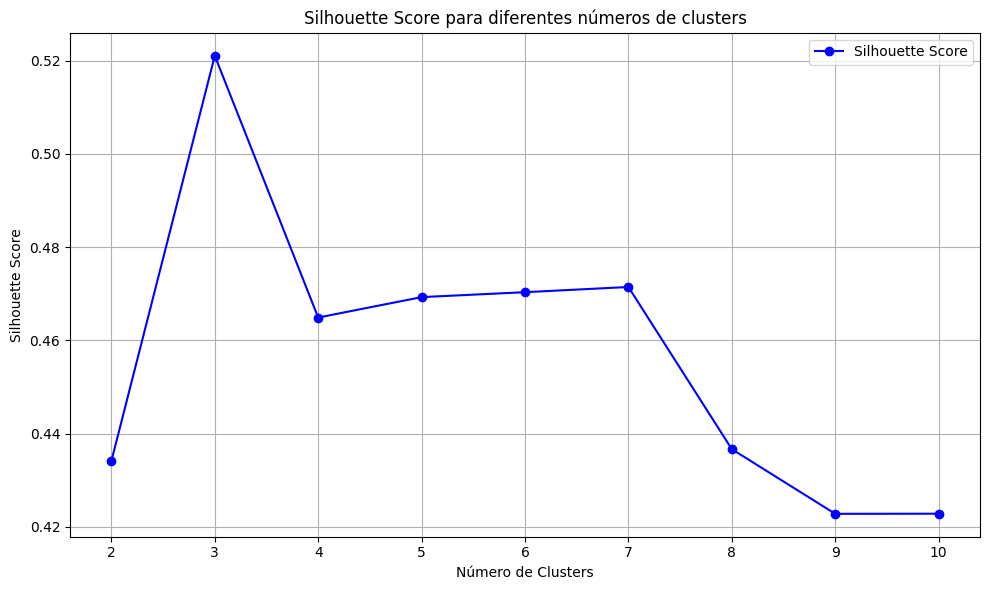

In [31]:
import matplotlib.pyplot as plt

# Datos proporcionados
num_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette_scores = [0.43409526348114014, 0.5210404396057129, 0.4648796319961548, 
                     0.4692618250846863, 0.47031867504119873, 0.47143399715423584, 
                     0.4366404712200165, 0.42277637124061584, 0.4228011667728424]

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(num_clusters, silhouette_scores, marker='o', linestyle='-', color='b', label='Silhouette Score')
plt.title('Silhouette Score para diferentes números de clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(num_clusters)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Mostrar el gráfico
plt.show()


Como se ve, el mejor Silhouette Score se logra con 3 clusters

In [38]:
# Realizar recomendaciones
# Cargar las características codificadas
X_encoded = pd.read_pickle("data_wines/encoded_features/encoded_features.pkl")

In [39]:
# Realizar clustering usando KMeans
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10).fit(X_encoded)

In [40]:
# Cargar df_user
df_user = pd.read_csv("Datos/XWines_Slim_10K_users.csv")
ratings = pd.read_csv("Datos/XWines_Slim_150K_ratings.csv")


# Supongamos que queremos obtener las 10 mejores recomendaciones para el usuario con UserID...
user_id = 1356810
recommendation_count = 10

/tmp/ipykernel_353014/3055652204.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings = pd.read_csv("Datos/XWines_Slim_150K_ratings.csv")


In [41]:
# Verificar si el usuario está en el dataframe
if user_id not in df_user['UserID'].values:
    print(f"UserID {user_id} no encontrado en df_user.")
else:
    # Encontrar la asignación de cluster para el usuario
    user_index = df_user[df_user['UserID'] == user_id].index[0]
    user_cluster = kmeans.labels_[user_index]

    # Obtener los índices de todos los usuarios en el mismo cluster
    cluster_indices = np.where(kmeans.labels_ == user_cluster)[0]

    # Cargar los datos de ratings
    cluster_ratings = pd.read_csv("Datos/XWines_Slim_150K_ratings.csv")

    # Obtener los ratings de todos los vinos por usuarios en el mismo cluster
    cluster_ratings = cluster_ratings.loc[cluster_ratings['UserID'].isin(df_user.iloc[cluster_indices]['UserID'])][['WineID', 'Rating']]

    # Calcular el rating promedio para cada vino
    avg_ratings = cluster_ratings.groupby(['WineID']).mean()

    # Ordenar los vinos por su rating promedio y obtener las 10 mejores recomendaciones
    top_n_recommendations = avg_ratings.sort_values(by='Rating', ascending=False).head(recommendation_count)
    # print(top_n_recommendations)

    # Cargar los nombres de los vinos
    wine_names = pd.read_csv('Datos/XWines_Slim_1K_wines.csv', sep=',', encoding='latin-1', header=0, usecols=['WineID', 'WineName'])

    # Imprimir las recomendaciones con nombres de vinos
    for wine_id in top_n_recommendations.index.values:
        wine_name = wine_names.loc[wine_names['WineID'] == wine_id]['WineName'].values[0]
        print(wine_name)

    # id de los vinos recomendados
    # print(top_n_recommendations.index.values)

LorenzhÃ¶fer Riesling Beerenauslese
Grappa Riserva Botti da Sherry
Tre Soli Tre Grappa Invecchiata
Solari
Tychson Hill Vineyard Cabernet Sauvignon
OenothÃ¨que Brut Champagne
LaurÃ©ne Pinot Noir
Red Blend
Grange
Fortis Cabernet Sauvignon


/tmp/ipykernel_353014/1823164379.py:13: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  cluster_ratings = pd.read_csv("Datos/XWines_Slim_150K_ratings.csv")


In [42]:
df_wines = pd.read_csv('Datos/XWines_Slim_1K_wines.csv')
df_wines.head(1)

,WineID,WineName,Type,Elaborate,Grapes,Harmonize,ABV,Body,Acidity,Code,Country,RegionID,RegionName,WineryID,WineryName,Website,Vintages
0,100001,Espumante Moscatel,Sparkling,Varietal/100%,['Muscat/Moscato'],"['Pork', 'Rich Fish', 'Shellfish']",7.5,Medium-bodied,High,BR,Brazil,1001,Serra Gaúcha,10001,Casa Perini,http://www.vinicolaperini.com.br,"[2020, 2019, 2018, 2017, 2016, 2015, 2014, 201..."


In [43]:
# Cargar los nombres de los vinos
wine_names = pd.read_csv('Datos/XWines_Slim_1K_wines.csv', sep=',', encoding='latin-1', header=0, usecols=['WineID', 'WineName', 'Type', 'Elaborate', 'Grapes'])

# Imprimir las recomendaciones con nombres de vinos
for wine_id in top_n_recommendations.index.values:
    wine_name = wine_names.loc[wine_names['WineID'] == wine_id].values[0]
    # print bonito
    print(f"WineName: {wine_name[1]}")
    print(f"Type: {wine_name[2]}")
    print(f"Elaborate: {wine_name[3]}")
    print(f"Grapes: {wine_name[4]}")
    print("\n")

WineName: LorenzhÃ¶fer Riesling Beerenauslese
Type: Dessert
Elaborate: Varietal/100%
Grapes: ['Riesling']


WineName: Grappa Riserva Botti da Sherry
Type: Dessert
Elaborate: Varietal/100%
Grapes: ['Nebbiolo']


WineName: Tre Soli Tre Grappa Invecchiata
Type: Dessert
Elaborate: Varietal/100%
Grapes: ['Nebbiolo']


WineName: Solari
Type: Red
Elaborate: Varietal/100%
Grapes: ['Cabernet Sauvignon']


WineName: Tychson Hill Vineyard Cabernet Sauvignon
Type: Red
Elaborate: Varietal/100%
Grapes: ['Cabernet Sauvignon']


WineName: OenothÃ¨que Brut Champagne
Type: Sparkling
Elaborate: Assemblage/Blend
Grapes: ['Pinot Noir', 'Chardonnay']


WineName: LaurÃ©ne Pinot Noir
Type: Red
Elaborate: Varietal/100%
Grapes: ['Pinot Noir']


WineName: Red Blend
Type: Red
Elaborate: Assemblage/Blend
Grapes: ['Cabernet Sauvignon', 'Cabernet Franc', 'Merlot', 'Petit Verdot']


WineName: Grange
Type: Red
Elaborate: Varietal/100%
Grapes: ['Syrah/Shiraz']


WineName: Fortis Cabernet Sauvignon
Type: Red
Elaborate: 

Se hacen predicciones a todos los vinos del dataset para así poder calcular rmse, precision, recall y f1-score. De otra forma, habrian vinos a los cuales no se predice un rating segun el usuario, pero que este si ha calificado, por lo que se intentaría comparar número con Nan.

# Vista en detalle de recomendaciones vs rankings reales

In [44]:
# mostrar rating real vs rating predicho de los items que rankea el usuario
# Cargar los datos de ratings
ratings = pd.read_csv("Datos/XWines_Slim_150K_ratings.csv")

/tmp/ipykernel_353014/3303984368.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings = pd.read_csv("Datos/XWines_Slim_150K_ratings.csv")


In [45]:
# Obtener los ratings del usuario
user_ratings = ratings.loc[ratings['UserID'] == user_id]

In [46]:
for wine_id in top_n_recommendations.index:
        wine_index = top_n_recommendations.index.values.tolist().index(wine_id)
        predicted_rating = top_n_recommendations.iloc[wine_index]['Rating']

In [47]:
# Obtener los ratings predichos para los vinos que ha rankeado el usuario
predicted_ratings = []


for wine_id in user_ratings['WineID']:
    if wine_id in top_n_recommendations.index:
        wine_index = top_n_recommendations.index.values.tolist().index(wine_id)
        predicted_rating = top_n_recommendations.iloc[wine_index]['Rating']
    else:
        predicted_rating = np.nan  # Si el vino no está en las recomendaciones, asignamos NaN
    predicted_ratings.append(predicted_rating)

    # Redondear los ratings predichos al valor permitido más cercano
allowed_ratings = np.arange(1, 5.5, 0.5)
predicted_ratings = [min(allowed_ratings, key=lambda x: abs(x - r)) 
                             if not np.isnan(r) else np.nan for r in predicted_ratings]

# Imprimir los ratings reales y predichos
print("Real Ratings:", user_ratings['Rating'].values)
print("Predicted Ratings:", predicted_ratings)

Real Ratings: [4.5 4.5 5.  5.  4.  4.5 3.5 4.  4.  4.  4.  4.  3.5 4.  4.  3.5 3.  4.
 4.  3.5]
Predicted Ratings: [nan, nan, 5.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


In [48]:
# tabla de real vs predicho
print(pd.DataFrame({'Real': user_ratings['Rating'].values, 'Predicted': predicted_ratings}))

# Redondear los ratings predichos en top_n_recommendations
top_n_recommendations['Rating'] = [min(allowed_ratings, key=lambda x: abs(x - r)) 
                                    if not np.isnan(r) else np.nan 
                                    for r in top_n_recommendations['Rating']]

print(top_n_recommendations)

    Real  Predicted
0    4.5        NaN
1    4.5        NaN
2    5.0        5.0
3    5.0        NaN
4    4.0        NaN
5    4.5        NaN
6    3.5        NaN
7    4.0        NaN
8    4.0        NaN
9    4.0        NaN
10   4.0        NaN
11   4.0        NaN
12   3.5        NaN
13   4.0        NaN
14   4.0        NaN
15   3.5        NaN
16   3.0        NaN
17   4.0        NaN
18   4.0        NaN
19   3.5        NaN
        Rating
WineID        
111328     5.0
151878     5.0
144337     5.0
182711     5.0
183379     5.0
112084     5.0
181199     4.5
181280     4.5
174184     4.5
182169     4.5


# Evaluación

## Métricas de 

In [49]:
df_test = pd.read_csv("Datos/XWines_Test_1K_ratings.csv")
df_test.head()

,RatingID,UserID,WineID,Vintage,Rating,Date
0,3211,1209683,111478,1959,4.5,2016-08-08 00:50:22
1,27878,1209980,111478,1975,4.0,2018-08-12 17:09:39
2,31227,1258705,111478,1975,5.0,2014-11-16 19:52:38
3,41946,1139706,111478,1979,5.0,2014-12-22 02:30:15
4,61700,1240747,111478,1982,4.5,2019-10-21 02:01:10


In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score

In [51]:
# Definir la función para predecir ratings
def predict_rating(user_id, wine_id):
    user_index = df_user[df_user['UserID'] == user_id].index[0]
    user_cluster = kmeans.labels_[user_index]
    cluster_indices = np.where(kmeans.labels_ == user_cluster)[0]
    cluster_ratings = ratings.loc[(ratings['UserID'].isin(df_user.iloc[cluster_indices]['UserID'])) & (ratings['WineID'] == wine_id)]['Rating']
    if len(cluster_ratings) > 0:
        predicted_rating = cluster_ratings.mean()
    else:
        predicted_rating = ratings['Rating'].mean()  # Fallback al promedio global si no hay datos en el cluster
    return predicted_rating

In [52]:
df_test['predicted_rating'] = df_test.apply(lambda row: predict_rating(row['UserID'], row['WineID']), axis=1)

In [53]:
rmse = np.sqrt(mean_squared_error(df_test['Rating'], df_test['predicted_rating']))
mae = mean_absolute_error(df_test['Rating'], df_test['predicted_rating'])

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 0.5685275791169739
MAE: 0.41530585805278936


In [55]:
# Definir umbral de relevancia
relevance_threshold = 4.0

In [56]:
df_test.head()

,RatingID,UserID,WineID,Vintage,Rating,Date,predicted_rating
0,3211,1209683,111478,1959,4.5,2016-08-08 00:50:22,4.329897
1,27878,1209980,111478,1975,4.0,2018-08-12 17:09:39,4.288390
2,31227,1258705,111478,1975,5.0,2014-11-16 19:52:38,4.288390
3,41946,1139706,111478,1979,5.0,2014-12-22 02:30:15,4.288390
4,61700,1240747,111478,1982,4.5,2019-10-21 02:01:10,4.329897


In [58]:
print(f"Precision y Recall con ratings reales y predichos con treshold {relevance_threshold}")

actual_ratings = ratings['Rating']
# Convertir ratings reales y predichos a valores binarios basados en el umbral
actual_relevance = (df_test['Rating'] >= relevance_threshold).astype(int)
predicted_relevance = (df_test['predicted_rating'] >= relevance_threshold).astype(int)

# Calcular Precision, Recall y F1-score
precision_value = precision_score(actual_relevance, predicted_relevance, average='weighted')
recall_value = recall_score(actual_relevance, predicted_relevance, average='weighted')
f1_value = f1_score(actual_relevance, predicted_relevance, average='weighted')

print(f"Precision: {precision_value:.2f}")
print(f"Recall: {recall_value:.2f}")
print(f"F1 Score: {f1_value:.2f}")

Precision y Recall con ratings reales y predichos con treshold 4.0
Precision: 0.75
Recall: 0.66
F1 Score: 0.64


## Métricas de novedad y diversidad: average_novelty e intra-list diversity

Para estas métricas debemos considerar solo los items a recomendar al usuario. Proponemos una recomendación de 10 vinos al usuario. Estos vinos corresponden a los 10 vinos que el modelo predice con mejor rating.

In [60]:
def average_novelty(recommended_items, item_popularity, total_users):
    novelty_scores = [np.log2(total_users / item_popularity[item]) for item in recommended_items if item in item_popularity]
    return np.mean(novelty_scores)

item_popularity = ratings['WineID'].value_counts().to_dict()

# Verificar el resultado
# print(item_popularity)

# Ejemplo de uso:
recommended_items = top_n_recommendations.index  
total_users = ratings['UserID'].nunique()  # Total de usuarios únicos en el sistema

novelty = average_novelty(recommended_items, item_popularity, total_users)
print(f"Average Novelty: {novelty:.2f}")

Average Novelty: 8.89
